# Machine Learning Project (Drug Design)
#### Approach to the problem
1- **Selection of the Network Architecture (VAE composed of LSTM Encoder & Decoder)**
- Data collection in **SMILES** format.
- SMILES represent the chemical compounds in string format.
- Since this is a **sequence task, LSTM** is the preferred choice of the neural network architecture for generating new SMILES string.

2- **Data Preprocessing Steps**
- Collect all the **unique characters** from the dataset.
- Create **two dictionaries**, one mapping all the unique characters to the index while the other mapping index back to character.
- Encode all the SMILES string into **one hot vectors** (character based) to feed into the network.
- Append **start token** at the beginning of each SMILE string and **end token** to mark the end of the string. 
- Make all the SMILES string of **same length** for training in batch by padding smaller SMILE strings with end token.
- **Labels will be shifted** by one unit from the inputs for **teacher forcing method** to train the sequence model.
- Build the lstm encoder and decoder network.
- Train the network end to end using one hot encoded SMILES string.

3- **Inference from the decoder**
- After training the network, feed random samples to the decoder to generate new SMILES string. 

## Import necessary modules

In [5]:
import os
import tarfile
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K

tf.random.set_seed(42)

### Load smiles data into pandas dataframe

In [ ]:
smi_file = "C:\\Users\\LENOVO LEGION\\Desktop\\Machine Learning\\New Compound\\fda.csv"
data_df = pd.read_csv(smi_file)
data_df.head()

### Train and validation split

In [7]:
# split the data into train and validation set
x_train, x_val = train_test_split(data_df['smiles'], test_size = 0.1, random_state = 42)

print(f'Shape of x_train: {x_train.shape}')
print(f'Shape of x_val: {x_val.shape}')

Shape of x_train: (1453,)
Shape of x_val: (162,)


### Dictionary of unique characters

In [8]:
# Unique character set with start and end tokens
char_set = set(''.join(list(data_df.smiles)) + '!E')

# character to int mapping
char_to_int = dict((c, i) for i, c in enumerate(char_set))

# int to character mapping
int_to_char = dict((i, c) for i, c in enumerate(char_set))

# maximum length of sequence
seq_len = max([len(smile) for smile in data_df.smiles]) + 2  

print(f'Character to integer dictionary: \n {char_to_int}')
print('\n')
print(f'Integer to character dictionary: \n {int_to_char}')

Character to integer dictionary: 
 {'F': 0, '2': 1, 'C': 2, 'E': 3, 'O': 4, '-': 5, 'N': 6, 'o': 7, '/': 8, 'l': 9, '=': 10, '[': 11, '(': 12, 'n': 13, 'r': 14, 'H': 15, 'c': 16, 'P': 17, ')': 18, '5': 19, '@': 20, '4': 21, '!': 22, 'S': 23, 's': 24, '8': 25, '1': 26, '3': 27, '\\': 28, 'i': 29, ']': 30, 'B': 31, '7': 32, '6': 33, '#': 34, '+': 35, 'I': 36}


Integer to character dictionary: 
 {0: 'F', 1: '2', 2: 'C', 3: 'E', 4: 'O', 5: '-', 6: 'N', 7: 'o', 8: '/', 9: 'l', 10: '=', 11: '[', 12: '(', 13: 'n', 14: 'r', 15: 'H', 16: 'c', 17: 'P', 18: ')', 19: '5', 20: '@', 21: '4', 22: '!', 23: 'S', 24: 's', 25: '8', 26: '1', 27: '3', 28: '\\', 29: 'i', 30: ']', 31: 'B', 32: '7', 33: '6', 34: '#', 35: '+', 36: 'I'}


In [9]:
print(f'Character set: {str(char_set)}')
print(f'Number of characters: {len(char_set)}\t Length of sequence: {seq_len}')

Character set: {'F', '2', 'C', 'E', 'O', '-', 'N', 'o', '/', 'l', '=', '[', '(', 'n', 'r', 'H', 'c', 'P', ')', '5', '@', '4', '!', 'S', 's', '8', '1', '3', '\\', 'i', ']', 'B', '7', '6', '#', '+', 'I'}
Number of characters: 37	 Length of sequence: 212


### One hot encoding of sequence data

In [10]:
def one_hot_encoding(smiles_col):
  # array of shape (num_examples, time_stamp, input_dim) initialized with zeros 
  one_hot =  np.zeros((smiles_col.shape[0], seq_len, len(char_set)), dtype = np.int8)
  # iterate over each smile string
  for index, smile in enumerate(smiles_col):
    # encode the start token
    one_hot[index, 0, char_to_int["!"]] = 1
    # encode the characters of smile string
    for row, char in enumerate(smile):
        one_hot[index, row + 1, char_to_int[char]] = 1
    # encode the end token
    one_hot[index, len(smile) + 1:, char_to_int['E']] = 1
  # return input and the output
  return one_hot[:, 0:-1, :], one_hot[:, 1:, :]

### Visualize the one hot encoded data

C[C@@H](c1ncncc1F)[C@](O)(Cn1cncn1)c1ccc(F)cc1F


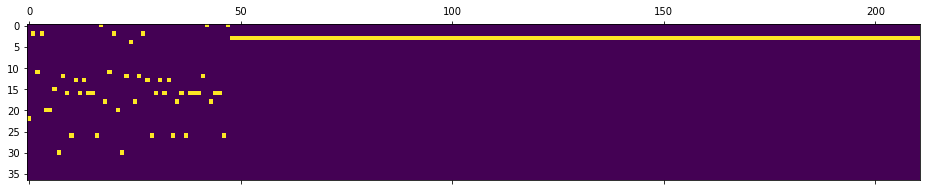

In [11]:
# One hot encoded train and validation data
X_train, Y_train = one_hot_encoding(x_train.values)
X_val, Y_val = one_hot_encoding(x_val.values)

# Print the first smile string
print(x_train.iloc[0])

# show the one hot encoded version of the string
plt.matshow(X_train[0].T)

In [12]:
# print the first smile string sequence with start and end tokens
"".join([int_to_char[idx] for idx in np.argmax(X_train[0, :, :], axis = 1)])

'!C[C@@H](c1ncncc1F)[C@](O)(Cn1cncn1)c1ccc(F)cc1FEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE'

In [13]:
# input shape of the model
input_shape = X_train.shape[1:]

# output shape of the model
output_dim = Y_train.shape[-1]

# latent dimension 
latent_dim = 64

# lstm units
lstm_dim = 64

### Build Encoder Model

In [14]:
# input layer of the encoder
encoder_inputs = layers.Input(shape = input_shape)

# internal states of the encoder (default activation is tanh)
outputs, state_h, state_c = layers.LSTM(lstm_dim, return_state = True, unroll = False)(encoder_inputs)

# concatenation of cell state and hidden state 
concat_states = layers.Concatenate(axis = -1)([state_h, state_c])

latent_outputs = layers.Dense(latent_dim, activation = "relu")(concat_states)

### Model building

In [15]:
# decode the cell and hidden states of the encoder
h_decoded =  layers.Dense(lstm_dim, activation = "relu")(latent_outputs)
c_decoded =  layers.Dense(lstm_dim, activation = "relu")(latent_outputs)

# decoded states
decoded_states = [h_decoded, c_decoded]

# input layer for decoder
decoder_inputs = layers.Input(shape = input_shape)

# hidden layers
decoder_lstm = layers.LSTM(lstm_dim, return_sequences = True, unroll = False)
decoder_outputs = decoder_lstm(decoder_inputs, initial_state = decoded_states)
decoder_outputs = layers.Dense(output_dim, activation = 'softmax')(decoder_outputs)

# Define the model
model = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

# print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 211, 37)]    0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 64),         26112       ['input_1[0][0]']                
                                 (None, 64),                                                      
                                 (None, 64)]                                                      
                                                                                                  
 concatenate (Concatenate)      (None, 128)          0           ['lstm[0][1]',                   
                                                                  'lstm[0][2]']               

### Compile and fit the model
- I stopped training after 65 epochs. 

In [17]:
# set learning rate for the model
learning_rate = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 10, min_lr = 0.000001, verbose = 1, min_delta = 1e-5)

# set the optimizer for the model
opt = tf.keras.optimizers.Adam(lr = 0.005) 

# compile the model
model.compile(optimizer = opt, loss = 'categorical_crossentropy')

# fit the model
model.fit([X_train, X_train], Y_train, epochs = 10, batch_size = 256, shuffle = True, callbacks = [learning_rate], validation_data = ([X_val, X_val], Y_val))

Epoch 1/10
6/6 [==============================] - 6s 605ms/step - loss: 1.0876 - val_loss: 0.9780 - lr: 0.0050
Epoch 2/10
6/6 [==============================] - 3s 496ms/step - loss: 0.9493 - val_loss: 0.8526 - lr: 0.0050
Epoch 3/10
6/6 [==============================] - 3s 481ms/step - loss: 0.8417 - val_loss: 0.7623 - lr: 0.0050
Epoch 4/10
6/6 [==============================] - 3s 499ms/step - loss: 0.7574 - val_loss: 0.6960 - lr: 0.0050
Epoch 5/10
6/6 [==============================] - 3s 521ms/step - loss: 0.7000 - val_loss: 0.6649 - lr: 0.0050
Epoch 6/10
6/6 [==============================] - 3s 515ms/step - loss: 0.6825 - val_loss: 0.6526 - lr: 0.0050
Epoch 7/10
6/6 [==============================] - 3s 549ms/step - loss: 0.6681 - val_loss: 0.6378 - lr: 0.0050
Epoch 8/10
6/6 [==============================] - 3s 549ms/step - loss: 0.6514 - val_loss: 0.6211 - lr: 0.0050
Epoch 9/10
6/6 [==============================] - 3s 547ms/step - loss: 0.6332 - val_loss: 0.6044 - lr: 0.0050
E

### Model predictions on validation set

In [18]:
for i in range(100):
  # extract index of maximum probability
  idxs_pred = np.argmax(model.predict([X_val[i:i + 1], X_val[i:i + 1]]), axis = 2)

  # join the predicted smile string
  pred_smile = "".join([int_to_char[m] for m in idxs_pred[0]])[:-1]

  # original smile string
  idxs_original = np.argmax(X_val[i:i + 1], axis = 2)
  true_smile =  "".join([int_to_char[n] for n in idxs_original[0]])[1:]
  if true_smile != pred_smile:
    print(f'True smile representation: {true_smile}\n Predicted smile representation: {pred_smile}')

True smile representation: O=C1CN=C(c2ccccc2Cl)c2cc([N+](=O)[O-])ccc2N1EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
 Predicted smile representation: CCCCCCCCCCccccccccccccccccccc(CC)CCCCCCCccccEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
True smile representation: CCCCCCCC(=O)N[C@H](CN1CCCC1)[C@H](O)c1ccc2c(c1)OCCO2EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
 Predicted smile representation: CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCccccccccccEECCEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
True smile representation: C[N+]1(C)

True smile representation: CC1=C(/C=C/C(C)=C/C=C/C(C)=C\C(=O)O)C(C)(C)CCC1EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
 Predicted smile representation: CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
True smile representation: CN(C)c1ccc2nc3ccc(=[N+](C)C)cc-3sc2c1EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
 Predicted smile representation: CCCCCCccccccccccccccccC(CCCCCcccccccccEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
True smile representation: COC(=O)C1

True smile representation: Cc1ccc(-n2nccn2)c(C(=O)N2CCN(c3nc4cc(Cl)ccc4o3)CC[C@H]2C)c1EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
 Predicted smile representation: CCCCccccccccccccccccccccCcCCCCcccccccccccccccccccCCCCCCCCCCCEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
True smile representation: COc1ccc(C(=O)CC(=O)c2ccc(C(C)(C)C)cc2)cc1EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
 Predicted smile representation: CCCCCccccccCCcCCCCCCccccccccccCCCCCcccccccEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
True smile representation: Cc1cccc(C

True smile representation: COc1cc(N[C@H](C)CCCN)c2ncccc2c1EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
 Predicted smile representation: CCCCCccccCCCCCCCCCCCCCCCccccccccEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
True smile representation: CCCCN/C(O)=N/S(=O)(=O)c1ccc(C)cc1EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
 Predicted smile representation: CCCCCCCCCCCCCCCCCCCCCCCcccccccccccEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
True smile representation: CCN(Cc1cc

True smile representation: CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4C(=O)[C@H](Cc4ccccc4)N3C2=O)C[C@@H]2c3cccc4[nH]cc(c34)C[C@H]21EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
 Predicted smile representation: CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCccccccccCcCCCCCCCCCCCCCCccccCccCcccccccCCCCCCCCEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
True smile representation: CCC(=O)NCC[C@@H]1CCc2ccc3c(c21)CCO3EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
 Predicted smile representation: CCCCCCCCCCCCCCCCCCCCCCccccccccccEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
True smile representation: O=C(c1cc(

### Smiles to latent space

In [26]:
# construct the smiles to latent space model 
smiles_to_latent_space = tf.keras.Model(encoder_inputs, neck_outputs)

# save the model
smiles_to_latent_space.save("smile_latent.h5")

NotImplementedError: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.

In [20]:
# convert validation data into latent space
val_latent = smiles_to_latent_space.predict(X_val)

NameError: name 'smiles_to_latent_space' is not defined

### Latent space to lstm states

In [21]:
# latent input layer for decoding smiles data
latent_input = layers.Input(shape = (latent_dim,))

# reuse earlier dense layers
state_h_decoded =  model.get_layer('dense_1')(latent_input)
state_c_decoded =  model.get_layer('dense_2')(latent_input)

latent_to_states_model = tf.keras.Model(latent_input, [state_h_decoded, state_c_decoded])
latent_to_states_model.save("latent_state.h5")

In [22]:
# Model for random sampling
sample_decoder_inputs = layers.Input(batch_shape = (1, 1, input_shape[1]))
lstm_out = layers.LSTM(lstm_dim, return_sequences = True, unroll = False, stateful = True)(sample_decoder_inputs)
dense_out = layers.Dense(output_dim, activation = 'softmax')(lstm_out)

sample_model = tf.keras.Model(sample_decoder_inputs, dense_out)

In [ ]:
# Model for random sampling
inf_decoder_inputs = layers.Input(batch_shape = (1, 1, input_shape[1]))
inf_decoder_lstm = layers.LSTM(lstm_dim, return_sequences = True, unroll = False, stateful = True)

inf_decoder_outputs = inf_decoder_lstm(inf_decoder_inputs)
inf_decoder_dense = layers.Dense(output_dim, activation = 'softmax')
inf_decoder_outputs = inf_decoder_dense(inf_decoder_outputs)

sample_model = tf.keras.Model(inf_decoder_inputs, inf_decoder_outputs)

In [23]:
# Transfer learned weights
for i in range(1, 3):
  sample_model.layers[i].set_weights(model.layers[i + 6].get_weights())
sample_model.save("sample_model.h5")

sample_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(1, 1, 23)]              0         
_________________________________________________________________
lstm_2 (LSTM)                (1, 1, 64)                22528     
_________________________________________________________________
dense_4 (Dense)              (1, 1, 23)                1495      
Total params: 24,023
Trainable params: 24,023
Non-trainable params: 0
_________________________________________________________________


### This function will generate smiles from latent space 

In [28]:
def latent_to_smiles(latent):
  # decode states and Reset the LSTM cells
  states = latent_to_states_model.predict(latent)
  sample_model.layers[1].reset_states(states = [states[0], states[1]])
  # Prepare the input char
  start_idx = char_to_int["!"]
  sample_vec = np.zeros((1, 1, 23))
  sample_vec[0, 0, start_idx] = 1
  smiles = ""
  # Loop and predict next char
  for i in range(28):
    out = sample_model.predict(sample_vec)
    sample_idx = np.argmax(out)
    sample_char = int_to_char[sample_idx]
    if sample_char != "E":
      smiles = smiles + int_to_char[sample_idx]
      sample_vec = np.zeros((1, 1, 23))
      sample_vec[0, 0, sample_idx] = 1
    else:
      break
  return smiles

### First generated SMILE string

In [29]:
smiles = latent_to_smiles(val_latent[0:1])
smiles

'CC1=C2OCC=C2C=C1'

### Second generated SMILE string

In [30]:
smiles = latent_to_smiles(val_latent[1:2])
smiles

'CC(O)C=C(F)C1CO1'

### Third generated SMILE string

In [31]:
smiles = latent_to_smiles(val_latent[2:3])
smiles

'ONC(=N)C1=CCC=C1'